# Twitter Sentiment Analysis EDA

### **Table of Content:**

 1. [Importing and Discovering the Dataset](#head-1)  
 2. [Cleaning and Processing the Data](#head-2)  
  2.1. [Tokenization](#head-2-1)  
  2.2. [Lemmatization](#head-2-2)  
  2.3. [Cleaning the Data](#head-2-3)  
 3. [Visualizing the Data](#head-3)
 4. [Tweets and Time](#head-4)

# 1. Importing and Discovering the Dataset <a class="anchor" id="head-1"></a>

In [1]:
try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime
    
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

time: 953 ms


In [2]:
# Reading the dataset with no columns titles and with latin encoding 
df_raw = pd.read_csv('../data/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", header=None)

 # As the data has no column titles, we will add our own
df_raw.columns = ["label", "time", "date", "query", "username", "text"]

# Show the first 5 rows of the dataframe.
df_raw.head()

,label,time,date,query,username,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


time: 4.52 s


In [3]:
# Checking the data's output balance
# The label '4' denotes positive sentiment and '0' denotes negative sentiment
df_raw['label'].value_counts()

0    800000
4    800000
Name: label, dtype: int64

time: 16 ms


In [4]:
# Ommiting every column except for the text and the label, as we won't need any of the other information
df = df_raw[['label', 'text']]
df.head()

,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


time: 31 ms


# 2. Cleaning and Processing the Data <a class="anchor" id="head-2"></a>

## 2.1. Tokenization <a class="anchor" id="head-2-1"></a>

I use the **TweetTokenizer**; a Twitter-aware tokenizer provided by the *nltk* library. In addition to a standard tokenizer, this tokenizer will split the input text based on various criterions that are well suited for the tweets use case.

More info can be found at: https://www.nltk.org/api/nltk.tokenize.html#module-nltk.tokenize.casual.

In [5]:
from nltk.tokenize import TweetTokenizer

# The reduce_len parameter will allow a maximum of 3 consecutive repeating characters, while trimming the rest
# For example, it will tranform the word: 'Helloooooooooo' to: 'Hellooo'
tk = TweetTokenizer(reduce_len=True)

data = []

# Separating our features (text) and our labels into two lists to smoothen our work
X = df['text'].tolist()
Y = df['label'].tolist()

# Building our data list, that is a list of tuples, where each tuple is a pair of the tokenized text
# and its corresponding label
for x, y in zip(X, Y):
    if y == 4:
        data.append((tk.tokenize(x), 1))
    else:
        data.append((tk.tokenize(x), 0))
        
data[:5]

[(['@switchfoot',
   'http://twitpic.com/2y1zl',
   '-',
   'Awww',
   ',',
   "that's",
   'a',
   'bummer',
   '.',
   'You',
   'shoulda',
   'got',
   'David',
   'Carr',
   'of',
   'Third',
   'Day',
   'to',
   'do',
   'it',
   '.',
   ';D'],
  0),
 (['is',
   'upset',
   'that',
   'he',
   "can't",
   'update',
   'his',
   'Facebook',
   'by',
   'texting',
   'it',
   '...',
   'and',
   'might',
   'cry',
   'as',
   'a',
   'result',
   'School',
   'today',
   'also',
   '.',
   'Blah',
   '!'],
  0),
 (['@Kenichan',
   'I',
   'dived',
   'many',
   'times',
   'for',
   'the',
   'ball',
   '.',
   'Managed',
   'to',
   'save',
   '50',
   '%',
   'The',
   'rest',
   'go',
   'out',
   'of',
   'bounds'],
  0),
 (['my',
   'whole',
   'body',
   'feels',
   'itchy',
   'and',
   'like',
   'its',
   'on',
   'fire'],
  0),
 (['@nationwideclass',
   'no',
   ',',
   "it's",
   'not',
   'behaving',
   'at',
   'all',
   '.',
   "i'm",
   'mad',
   '.',
   'why',
   'a

time: 1min 22s


## 2.2. Lemmatization <a class="anchor" id="head-2-2"></a>

*nltk*'s **WordNetLemmatizer** takes as input two arguments: a list of tokens to be lemmatized as well as their corresponding *part of speech*. The most common parts of speech in english are nouns and verbs. In order to extract each token's part of speech, we will utilize *nltk*'s *post_tag* function, that takes an input a list of tokens, and returns a list of tuples, where each tuple is composed of a token and its corresponding position tag. Various position tags can be outputted from the pos_tag function, however the most notable ones are:
* **NNP**: Noun, proper, singular
* **NN**: Noun, common, singular or mass.
* **VBG**: Verb, gerund or present participle.
* **VBN**: Verb, past participle.

A full list of position tags can be found at: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

In [8]:
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('averaged_perceptron_tagger')

# Previewing the pos_tag() output
print(pos_tag(data[0][0]))

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\George\AppData\Roaming\nltk_data...


[('@switchfoot', 'NN'), ('http://twitpic.com/2y1zl', 'SYM'), ('-', ':'), ('Awww', 'NNP'), (',', ','), ("that's", 'VBZ'), ('a', 'DT'), ('bummer', 'NN'), ('.', '.'), ('You', 'PRP'), ('shoulda', 'VBP'), ('got', 'VBD'), ('David', 'NNP'), ('Carr', 'NNP'), ('of', 'IN'), ('Third', 'NNP'), ('Day', 'NNP'), ('to', 'TO'), ('do', 'VB'), ('it', 'PRP'), ('.', '.'), (';D', 'VB')]
time: 1.92 s


[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


In [9]:
def lemmatize_sentence(tokens):
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    for word, tag in pos_tag(tokens):
        # First, we will convert the pos_tag output tags to a tag format that the WordNetLemmatizer can interpret
        # In general, if a tag starts with NN, the word is a noun and if it stars with VB, the word is a verb.
        if tag.startswith('NN'):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'
        lemmatized_sentence.append(lemmatizer.lemmatize(word, pos))
    return lemmatized_sentence

# Previewing the WordNetLemmatizer() output
print(lemmatize_sentence(data[0][0]))

['@switchfoot', 'http://twitpic.com/2y1zl', '-', 'Awww', ',', "that's", 'a', 'bummer', '.', 'You', 'shoulda', 'get', 'David', 'Carr', 'of', 'Third', 'Day', 'to', 'do', 'it', '.', ';D']
time: 2.05 s


## 2.3. Cleaning the Data <a class="anchor" id="head-2-3"></a>

In [10]:
import re, string

# Stopwords are frequently-used words (such as “the”, “a”, “an”, “in”) that do not hold any meaning useful to extract sentiment.
from nltk.corpus import stopwords
STOP_WORDS = stopwords.words('english')

# A custom function defined in order to fine-tune the cleaning of the input text. This function is highly dependent on each usecase.
# Note: Only include misspelling or abbreviations of commonly used words. Including many minimally present cases would negatively impact the performance. 
def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token == 'amp' or token == 'quot' or token == 'lt' or token == 'gt' or token == '½25':
        return ''
    return token

# This function will be our all-in-one noise removal function
def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token, tag in pos_tag(tweet_tokens):
        # Eliminating the token if it is a link
        token = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+#]|[!*\(\),]|'\
                       '(?:%[0-9a-fA-F][0-9a-fA-F]))+','', token)
        # Eliminating the token if it is a mention
        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        if tag.startswith("NN"):
            pos = 'n'
        elif tag.startswith('VB'):
            pos = 'v'
        else:
            pos = 'a'

        lemmatizer = WordNetLemmatizer()
        token = lemmatizer.lemmatize(token, pos)

        cleaned_token = cleaned(token.lower())
        
        # Eliminating the token if its length is less than 3, if it is a punctuation or if it is a stopword
        if cleaned_token not in string.punctuation and len(cleaned_token) > 2 and cleaned_token not in STOP_WORDS:
            cleaned_tokens.append(cleaned_token)
            
    return cleaned_tokens

# Prevewing the remove_noise() output
print(remove_noise(data[0][0]))

['awww', "that's", 'bummer', 'shoulda', 'get', 'david', 'carr', 'third', 'day']
time: 16 ms


In [12]:
# As the Naive Bayesian classifier accepts inputs in a dict-like structure,
# we have to define a function that transforms our data into the required input structure
def list_to_dict(cleaned_tokens):
    return dict([token, True] for token in cleaned_tokens)

cleaned_tokens_list = []

# Removing noise from all the data
for tokens, label in data:
    cleaned_tokens_list.append((remove_noise(tokens), label))

final_data = []

# Transforming the data to fit the input structure of the Naive Bayesian classifier
for tokens, label in cleaned_tokens_list:
    final_data.append((list_to_dict(tokens), label))

# Previewing our final (tokenized, cleaned and lemmatized) data list
final_data[:5]

[({'awww': True,
   "that's": True,
   'bummer': True,
   'shoulda': True,
   'get': True,
   'david': True,
   'carr': True,
   'third': True,
   'day': True},
  0),
 ({'upset': True,
   "can't": True,
   'update': True,
   'facebook': True,
   'texting': True,
   '...': True,
   'might': True,
   'cry': True,
   'result': True,
   'school': True,
   'today': True,
   'also': True,
   'blah': True},
  0),
 ({'dive': True,
   'many': True,
   'time': True,
   'ball': True,
   'managed': True,
   'save': True,
   'rest': True,
   'bound': True},
  0),
 ({'whole': True,
   'body': True,
   'feel': True,
   'itchy': True,
   'like': True,
   'fire': True},
  0),
 ({'behave': True, "i'm": True, 'mad': True, "can't": True, 'see': True}, 0)]

time: 36min 56s


In [24]:
# save cleaned data to /data folder
# np.save("../data/cleaned.npy", final_data)

time: 8.69 s


# 3. Visualizing the Data <a class="anchor" id="head-3"></a>

**Word Clouds** are one of the best visualizations for words frequencies in text documents.<br>Essentially, what it does is that it produces an image with frequently-appearing words in the text document, where the most frequent words are showcased with bigger font sizes, and less frequent words with smaller font sizes.

Positive words


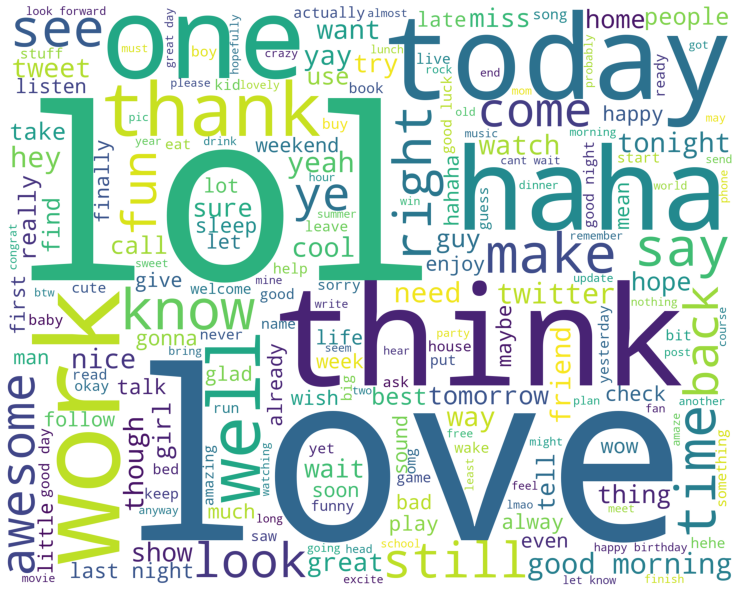

Negative words


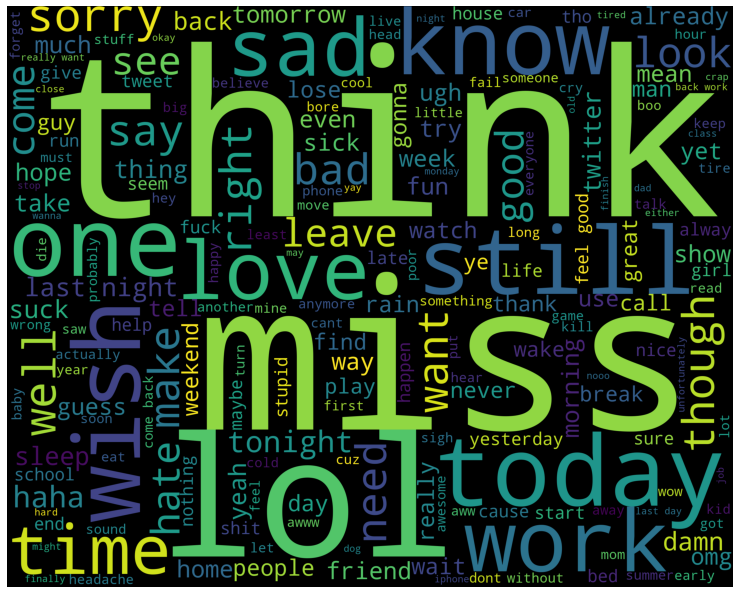

time: 2min


In [13]:
from wordcloud import WordCloud, STOPWORDS

positive_words = []
negative_words = []

# Separating out positive and negative words (i.e., words appearing in negative and positive tweets),
# in order to visualize each set of words independently
for i in range(len(cleaned_tokens_list)):
    if cleaned_tokens_list[i][1] == 1:
        positive_words.extend(cleaned_tokens_list[i][0])
    else:
        negative_words.extend(cleaned_tokens_list[i][0])

# Defining our word cloud drawing function
def wordcloud_draw(data, color = 'black'):
    wordcloud = WordCloud(stopwords = STOPWORDS,
                          background_color = color,
                          width = 2500,
                          height = 2000
                         ).generate(' '.join(data))
    plt.figure(1, figsize = (13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

print("Positive words")
wordcloud_draw(positive_words, 'white')
print("Negative words")
wordcloud_draw(negative_words)        

It's quite interesting to observe the (higher) occurence of *\"wish\"* and *\"love\"* in the negative tweets. But most of the words in the two plots follow the intrinsic.

That's it for the small detour! It's really fun to try and squeeze out every ounce of information from the data! And who knows, maybe we can combine this information with our current model, as to give more weights to a certain class depending on the date of the tweet!

# 4. Tweets and Time <a class="anchor" id="head-4"></a>

Since the dataset covers the datetime of a tweets post, I'm interested in *could the tweet date have any correlation(s) with the tweet sentiment?*

In [3]:
# Taking only the label and the date in order to work on them
df_date = df_raw.copy()[['label', 'date']]
df_date.head()

,label,date
0,0,Mon Apr 06 22:19:45 PDT 2009
1,0,Mon Apr 06 22:19:49 PDT 2009
2,0,Mon Apr 06 22:19:53 PDT 2009
3,0,Mon Apr 06 22:19:57 PDT 2009
4,0,Mon Apr 06 22:19:57 PDT 2009


time: 156 ms


In [4]:
# Adding a field to our dataframe, hour, containing the hour in which the tweet was published
df_date['hour'] = df_date.date.apply(lambda x: x[11:13]).astype('int32')
df_date.head()

,label,date,hour
0,0,Mon Apr 06 22:19:45 PDT 2009,22
1,0,Mon Apr 06 22:19:49 PDT 2009,22
2,0,Mon Apr 06 22:19:53 PDT 2009,22
3,0,Mon Apr 06 22:19:57 PDT 2009,22
4,0,Mon Apr 06 22:19:57 PDT 2009,22


time: 531 ms


In [5]:
# Adding a field to our dataframe, dow, containing the day of week in which the tweet was published
df_date['dow'] = df_date.date.apply(lambda x: x[:3]).astype('str')
df_date.head()

,label,date,hour,dow
0,0,Mon Apr 06 22:19:45 PDT 2009,22,Mon
1,0,Mon Apr 06 22:19:49 PDT 2009,22,Mon
2,0,Mon Apr 06 22:19:53 PDT 2009,22,Mon
3,0,Mon Apr 06 22:19:57 PDT 2009,22,Mon
4,0,Mon Apr 06 22:19:57 PDT 2009,22,Mon


time: 438 ms


In [6]:
# Building a pivot table that breaks-down the number of positive and negative tweets in each hour of the day
temporal_hour = pd.pivot_table(df_date, index='label', columns='hour', aggfunc='size', fill_value=0)
temporal_hour

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
label,,,,,,,,,,,,,,,,,,,,,
0,35582,30581,30171,31717,34946,37774,40076,42208,40166,36511,...,27077,28531,31594,29316,29422,31193,30102,36007,39018,39506
4,45283,44687,43820,42536,42049,40849,40776,41446,36121,30767,...,23303,22112,24126,22527,24063,26529,26957,32957,39310,45244


time: 266 ms


<AxesSubplot:xlabel='hour'>

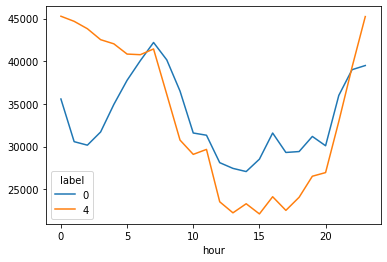

time: 281 ms


In [7]:
# Plotting our results
temporal_hour.transpose().plot()

It's interesting to see that it turns out that there's a relationship between the time of the tweet (in terms of hours of day) and whether this tweet has a positive or negative sentiment!

In fact, from this graph I concluded two things:

* There's a specific interval of time in which positive tweets outnumber the negative tweets, and another interval in which the opposite occurs.
* When the total number of tweets is relatively high, the majority of the tweets tend to have a positive sentiment. This *could* also mean that positive tweets come in big batches, maybe relating to a similar subject (soccer game, movie release, etc), whereas negative tweets are more sparsely distributed.

Also, you might find it weird that the biggest number of tweets occurs between 12AM and 7AM, however keep in mind that this is the raw date we've read from the data, and could quite possibly need to be converted to another timezone. As it stands, I cannot directly draw a conclusion as to which specific time frame favors positive or negative tweets, as I'm not entirely sure how to convert the given dates to the appropriate timezone of the collected data. So just look at the shape of the graph, without necesseraly pinpointing the hour coordinates.

In [8]:
# Transforming the above pilot table such that it now contains the percentage
# of negative/positive tweets in each hour of the day
temporal_hour = temporal_hour.iloc[:, :].apply(lambda x: x / x.sum())
temporal_hour

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
label,,,,,,,,,,,,,,,,,,,,,
0,0.440017,0.406295,0.407766,0.427148,0.453874,0.480445,0.495671,0.504554,0.526512,0.542689,...,0.537455,0.563375,0.567014,0.565477,0.550098,0.540401,0.527559,0.522113,0.498136,0.466147
4,0.559983,0.593705,0.592234,0.572852,0.546126,0.519555,0.504329,0.495446,0.473488,0.457311,...,0.462545,0.436625,0.432986,0.434523,0.449902,0.459599,0.472441,0.477887,0.501864,0.533853


time: 47 ms


<AxesSubplot:xlabel='hour'>

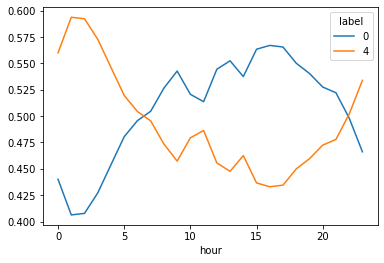

time: 203 ms


In [9]:
# Plotting our results
temporal_hour.transpose().plot()

In [10]:
# Building a pivot table that breaks-down the number of positive and negative tweets in each day of the week
temporal_dow = pd.pivot_table(df_date, index='label', columns='dow', aggfunc='size', fill_value=0)
temporal_dow

dow,Fri,Mon,Sat,Sun,Thu,Tue,Wed
label,,,,,,,
0,114600,132539,157734,145471,80132,101051,68473
4,110994,177666,173221,199084,25903,84799,28333


time: 203 ms


In [11]:
# Re-ordering our table
temporal_dow = temporal_dow[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]
temporal_dow

dow,Mon,Tue,Wed,Thu,Fri,Sat,Sun
label,,,,,,,
0,132539,101051,68473,80132,114600,157734,145471
4,177666,84799,28333,25903,110994,173221,199084


time: 15 ms


<AxesSubplot:xlabel='dow'>

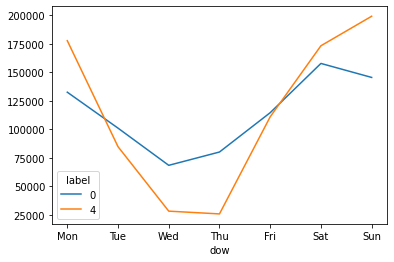

time: 234 ms


In [12]:
# Plotting our results
temporal_dow.transpose().plot()

Here, two insights can be drawn from the graph:

* People tend to tweet more positively during the weekends, when they relax and attend events, whereas negative tweets are dominant during the rest of the week, showcasing people's dissatisfaction with their work.
* A much bigger number of tweets is circulated during the weekend, relative to the rest of the week.

This actually slightly reinforces our prior hypotheses that *positive tweets come in big batches, maybe relating to a similar subject*, as such events usually occur on the weekends.

Also, keep in mind that this graph could also be shifted either to the left or to the right, as the tweets appearing to have a date *Monday 1AM* for example could end up being on *Sunday 8PM*, or vise versa.

In [13]:
# Transforming the above pilot table such that it now contains the percentage
# of negative/positive tweets in each day of the week
temporal_dow = temporal_dow.iloc[:, :].apply(lambda x: x / x.sum())
temporal_dow

dow,Mon,Tue,Wed,Thu,Fri,Sat,Sun
label,,,,,,,
0,0.427263,0.543723,0.707322,0.755713,0.507992,0.476603,0.4222
4,0.572737,0.456277,0.292678,0.244287,0.492008,0.523397,0.5778


time: 16 ms


<AxesSubplot:xlabel='dow'>

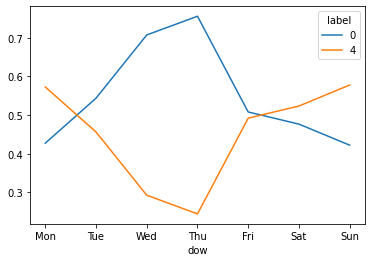

time: 172 ms


In [14]:
temporal_dow.transpose().plot()